# Import Library

In [1]:
# 데이터 처리 및 분석
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE # 차원 축소 라이브러리

# 머신러닝 전처리
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# # 머신러닝 모델
# import xgboost as xgb
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# 
# # 합성 데이터 생성
# from sdv.metadata import SingleTableMetadata
# from sdv.single_table import CTGANSynthesizer

# 데이터 샘플링
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

# 합성 데이터 평가
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# 1. 엑셀 파일들 불러오기
df1 = pd.read_csv("01.카드 회원정보/201807_회원정보.csv")
df2 = pd.read_csv("02.카드 신용정보/201807_신용정보.csv")
df3 = pd.read_csv("03.카드 승인매출정보/201807_승인매출정보.csv")
df4 = pd.read_csv("04.카드 청구정보/201807_청구정보.csv")
df5 = pd.read_csv("05.카드 잔액정보/201807_잔액정보.csv")
df6 = pd.read_csv("06.카드 채널정보/201807_채널정보.csv")
df7 = pd.read_csv("08.카드 성과정보/201807_성과정보.csv")

# 2. 이탈회원목록 CSV 불러오기
df_churn = pd.read_csv("이탈회원목록.csv")  # 열 이름: '발급회원번호', '이탈'

# 3. 이탈회원만 필터링 + '이탈' 컬럼 merge
def filter_and_merge(df, name):
    df_filtered = df[df['발급회원번호'].isin(df_churn['발급회원번호'])]
    df_merged = df_filtered.merge(df_churn, on='발급회원번호', how='left')
    print(f"{name} 처리 완료: {df_merged.shape}")
    return df_merged

df1 = filter_and_merge(df1, "df1")
df2 = filter_and_merge(df2, "df2")
df3 = filter_and_merge(df3, "df3")
df4 = filter_and_merge(df4, "df4")
df5 = filter_and_merge(df5, "df5")
df6 = filter_and_merge(df6, "df6")
df7 = filter_and_merge(df7, "df7")

df1 처리 완료: (2221257, 80)
df2 처리 완료: (2221257, 43)
df3 처리 완료: (2221257, 431)
df4 처리 완료: (2221257, 47)
df5 처리 완료: (2221257, 84)
df6 처리 완료: (2221257, 106)
df7 처리 완료: (2221257, 50)


In [3]:
print('df1.shape:', df1.shape)
print('df2.shape:', df2.shape)
print('df3.shape:', df3.shape)
print('df4.shape:', df4.shape)
print('df5.shape:', df5.shape)
print('df6.shape:', df6.shape)
print('df7.shape:', df7.shape)

df1.shape: (2221257, 80)
df2.shape: (2221257, 43)
df3.shape: (2221257, 431)
df4.shape: (2221257, 47)
df5.shape: (2221257, 84)
df6.shape: (2221257, 106)
df7.shape: (2221257, 50)


In [4]:
df_churn.shape

(2221257, 2)

In [5]:
label = pd.read_csv("label.csv")

In [6]:
label.head()

,필드한글명,필드영문명
0,VIP등급코드,code_vip
1,최상위카드등급코드,code_topcard_grade
2,회원여부_이용가능,yn_member_ups
3,소지여부_신용,yn_credit_pss
4,소지카드수_유효_신용,cnt_credit_vl_pss


In [7]:
# 1. 선택할 열 리스트 확보
selected_cols = label['필드한글명'].tolist()

# 2. 각 df에서 해당 열만 남기기 (교집합만 처리되도록)
df1 = df1[[col for col in df1.columns if col in selected_cols]]
df2 = df2[[col for col in df2.columns if col in selected_cols]]
df3 = df3[[col for col in df3.columns if col in selected_cols]]
df4 = df4[[col for col in df4.columns if col in selected_cols]]
df5 = df5[[col for col in df5.columns if col in selected_cols]]
df6 = df6[[col for col in df6.columns if col in selected_cols]]
df7 = df7[[col for col in df7.columns if col in selected_cols]]

In [8]:
print('df1.shape:', df1.shape)
print('df2.shape:', df2.shape)
print('df3.shape:', df3.shape)
print('df4.shape:', df4.shape)
print('df5.shape:', df5.shape)
print('df6.shape:', df6.shape)
print('df7.shape:', df7.shape)

df1.shape: (2221257, 16)
df2.shape: (2221257, 8)
df3.shape: (2221257, 50)
df4.shape: (2221257, 17)
df5.shape: (2221257, 19)
df6.shape: (2221257, 1)
df7.shape: (2221257, 8)


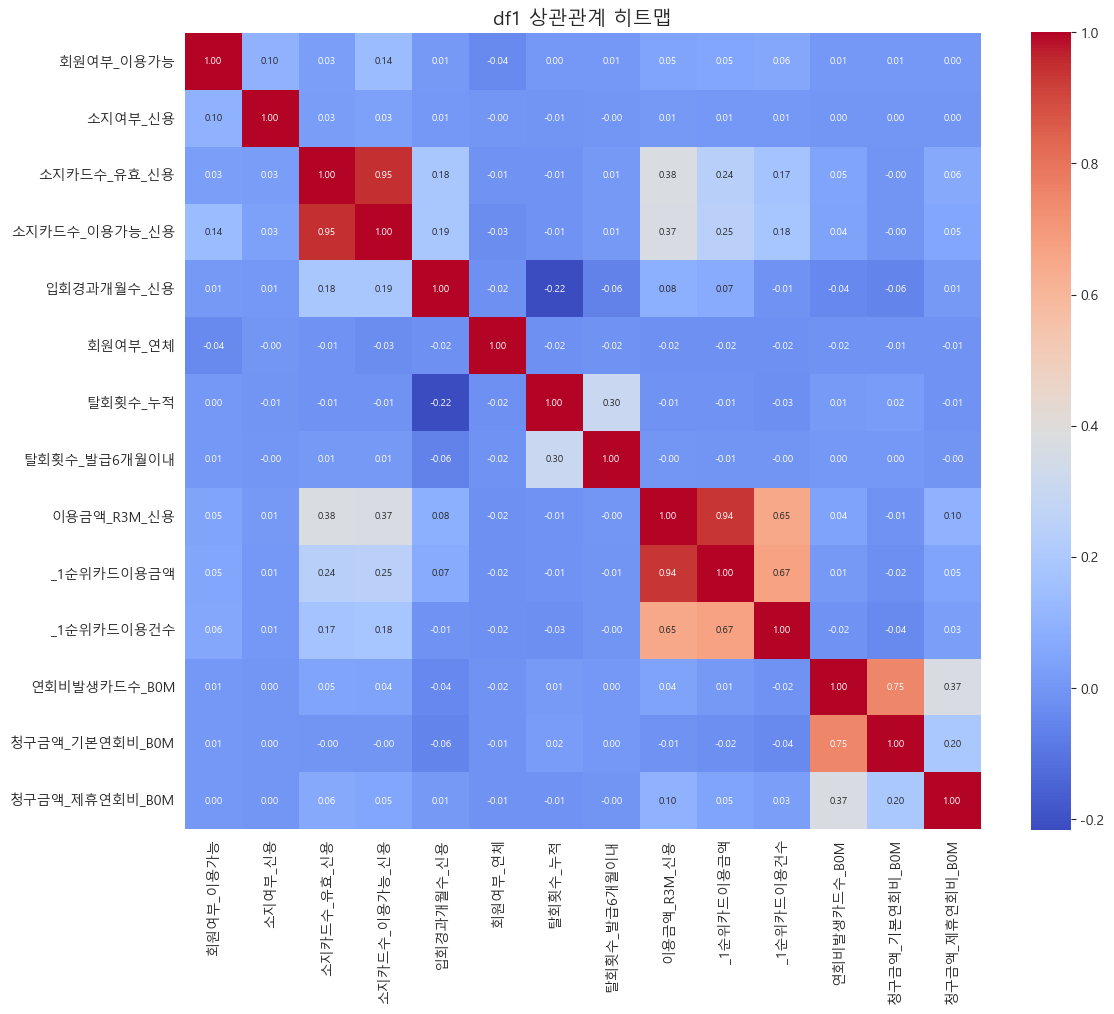

📌 df1의 상관계수 >= 0.8 변수쌍:
        변수1           변수2     상관계수
소지카드수_유효_신용 소지카드수_이용가능_신용 0.946865
이용금액_R3M_신용    _1순위카드이용금액 0.935264 



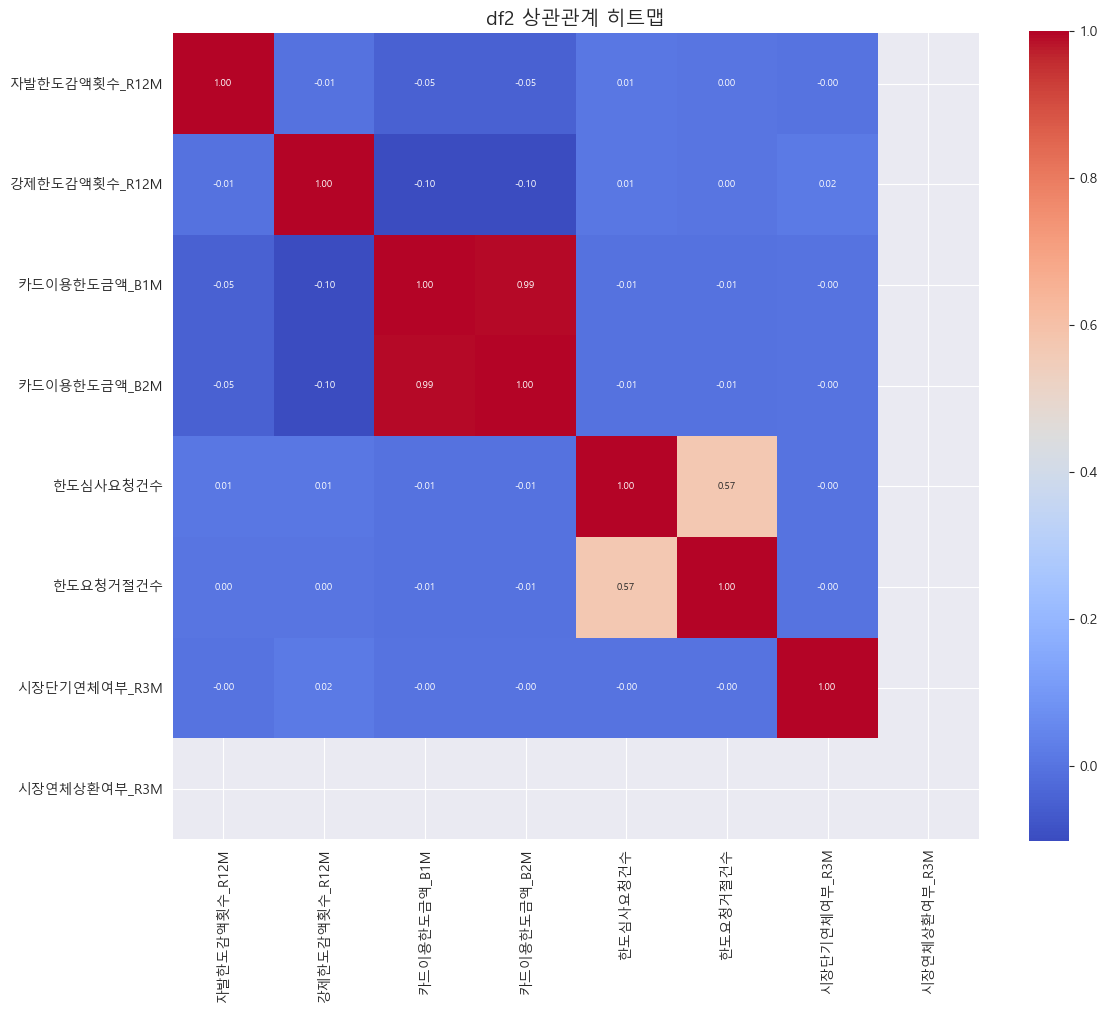

📌 df2의 상관계수 >= 0.8 변수쌍:
         변수1          변수2     상관계수
카드이용한도금액_B1M 카드이용한도금액_B2M 0.992346 



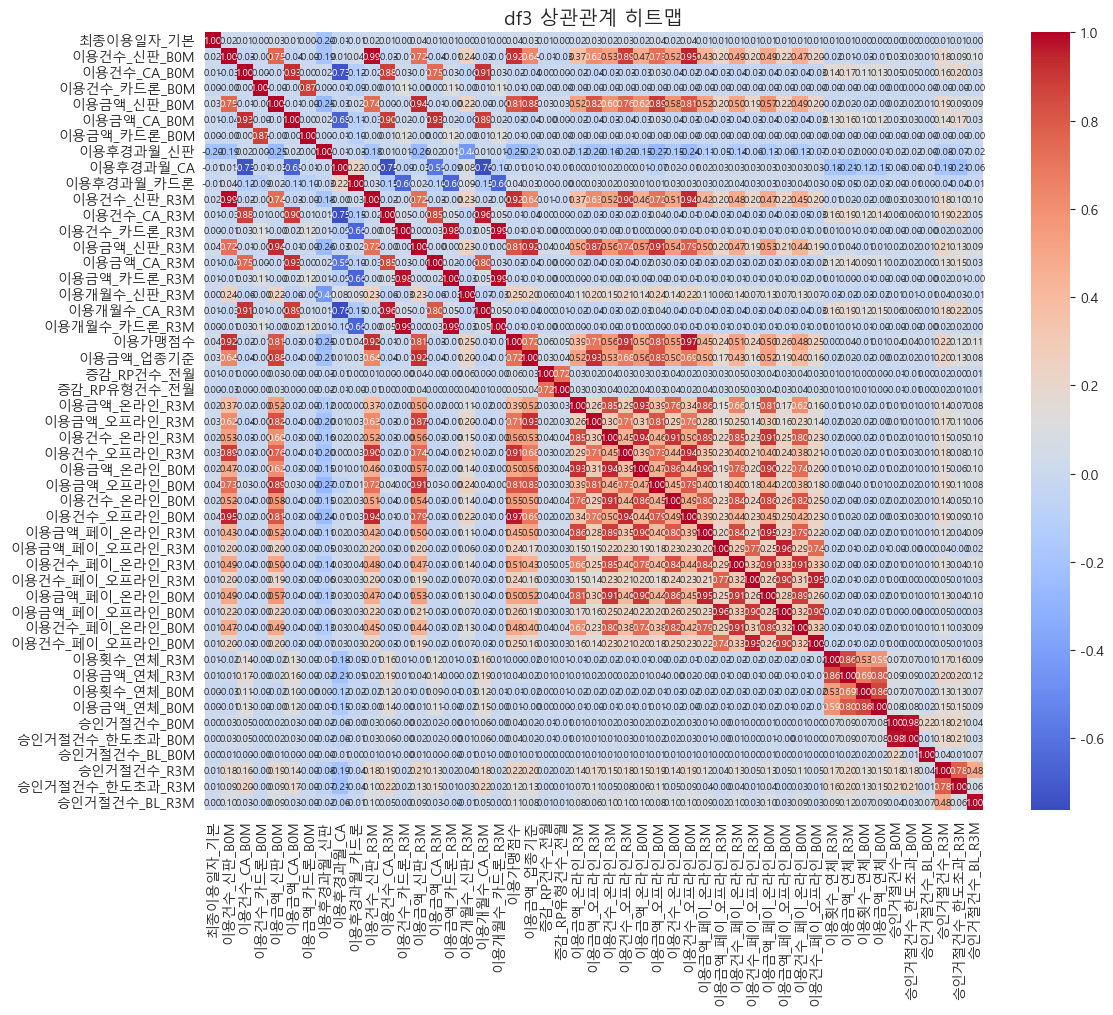

📌 df3의 상관계수 >= 0.8 변수쌍:
             변수1              변수2     상관계수
     이용건수_신판_B0M      이용건수_신판_R3M 0.991309
     이용건수_신판_B0M           이용가맹점수 0.919264
     이용건수_신판_B0M    이용건수_오프라인_R3M 0.887994
     이용건수_신판_B0M    이용건수_오프라인_B0M 0.945298
     이용건수_CA_B0M      이용금액_CA_B0M 0.926130
     이용건수_CA_B0M      이용건수_CA_R3M 0.881360
     이용건수_CA_B0M     이용개월수_CA_R3M 0.911818
    이용건수_카드론_B0M     이용금액_카드론_B0M 0.873377
     이용금액_신판_B0M      이용금액_신판_R3M 0.937352
     이용금액_신판_B0M           이용가맹점수 0.813952
     이용금액_신판_B0M        이용금액_업종기준 0.878474
     이용금액_신판_B0M    이용금액_오프라인_R3M 0.821390
     이용금액_신판_B0M    이용금액_오프라인_B0M 0.890714
     이용금액_신판_B0M    이용건수_오프라인_B0M 0.811726
     이용금액_CA_B0M      이용건수_CA_R3M 0.896245
     이용금액_CA_B0M      이용금액_CA_R3M 0.925475
     이용금액_CA_B0M     이용개월수_CA_R3M 0.889060
     이용건수_신판_R3M           이용가맹점수 0.921595
     이용건수_신판_R3M    이용건수_오프라인_R3M 0.898243
     이용건수_신판_R3M    이용건수_오프라인_B0M 0.942346
     이용건수_CA_R3M      이용금액_CA_R3M 0.851614
     이용건수_CA_R3M     이용개월수_CA_

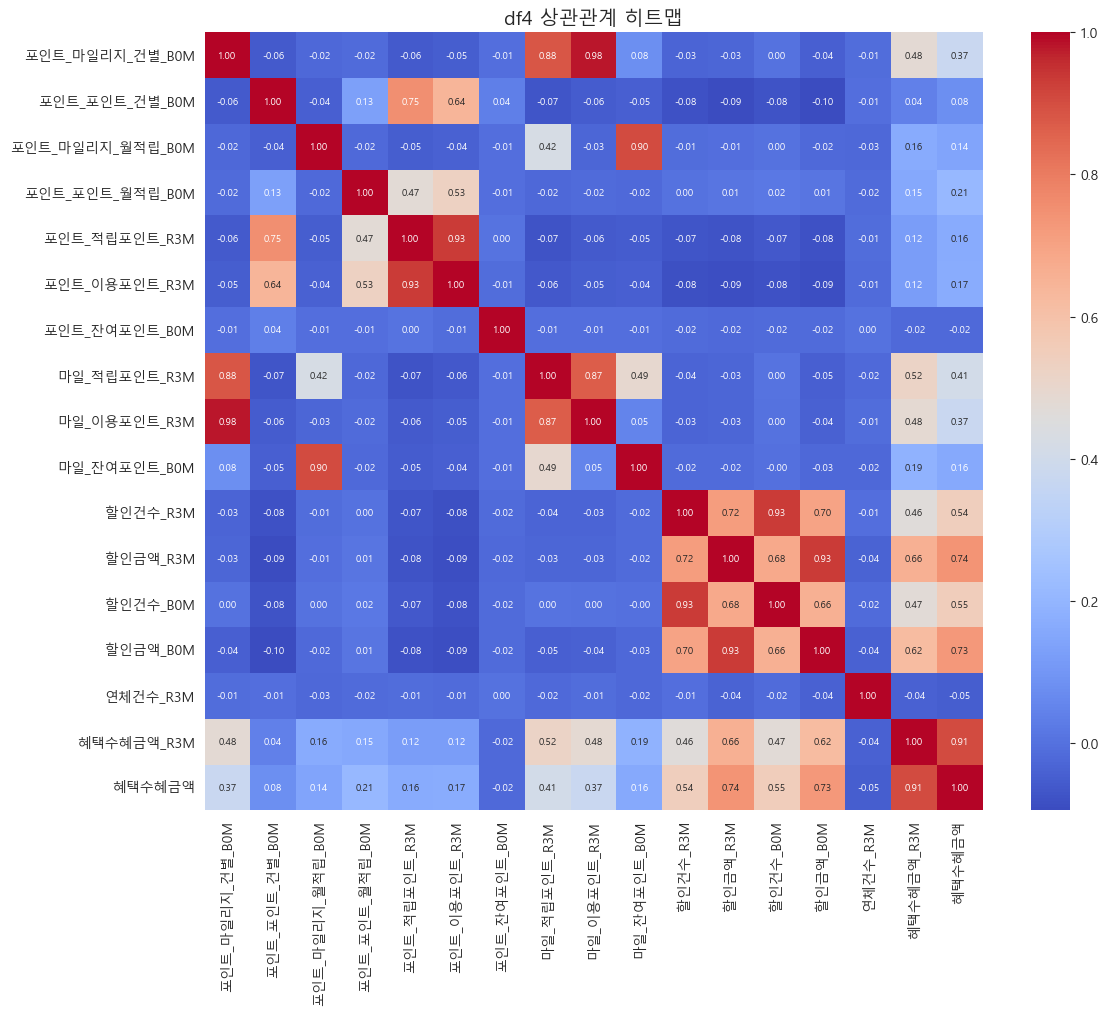

📌 df4의 상관계수 >= 0.8 변수쌍:
             변수1           변수2     상관계수
 포인트_마일리지_건별_B0M  마일_적립포인트_R3M 0.880592
 포인트_마일리지_건별_B0M  마일_이용포인트_R3M 0.980853
포인트_마일리지_월적립_B0M  마일_잔여포인트_B0M 0.903609
   포인트_적립포인트_R3M 포인트_이용포인트_R3M 0.933853
    마일_적립포인트_R3M  마일_이용포인트_R3M 0.868495
        할인건수_R3M      할인건수_B0M 0.932800
        할인금액_R3M      할인금액_B0M 0.933788
      혜택수혜금액_R3M        혜택수혜금액 0.905498 



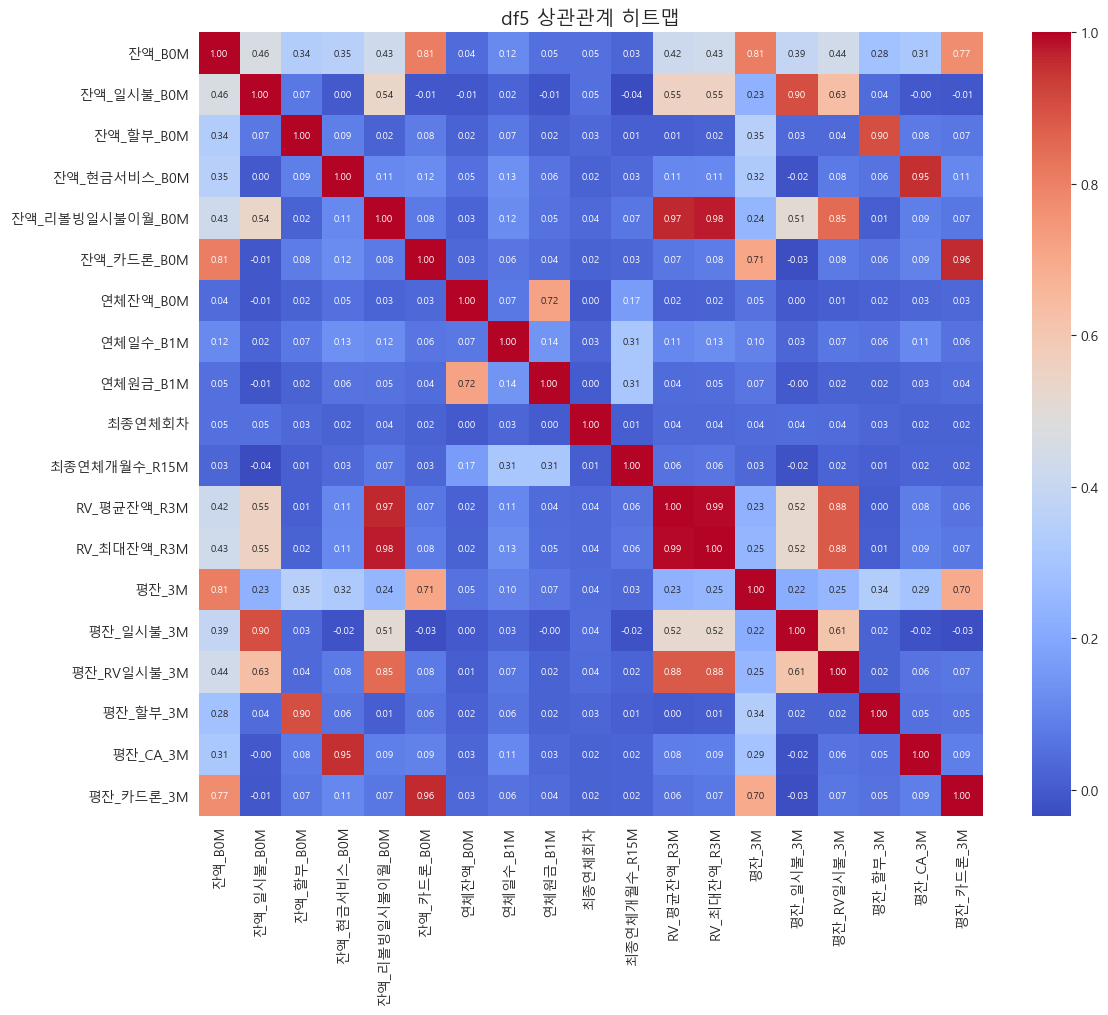

📌 df5의 상관계수 >= 0.8 변수쌍:
            변수1         변수2     상관계수
         잔액_B0M  잔액_카드론_B0M 0.807358
         잔액_B0M       평잔_3M 0.807304
     잔액_일시불_B0M   평잔_일시불_3M 0.904566
      잔액_할부_B0M    평잔_할부_3M 0.903336
   잔액_현금서비스_B0M    평잔_CA_3M 0.952446
잔액_리볼빙일시불이월_B0M RV_평균잔액_R3M 0.965034
잔액_리볼빙일시불이월_B0M RV_최대잔액_R3M 0.976995
잔액_리볼빙일시불이월_B0M 평잔_RV일시불_3M 0.848818
     잔액_카드론_B0M   평잔_카드론_3M 0.962488
    RV_평균잔액_R3M RV_최대잔액_R3M 0.992227
    RV_평균잔액_R3M 평잔_RV일시불_3M 0.879363
    RV_최대잔액_R3M 평잔_RV일시불_3M 0.880099 



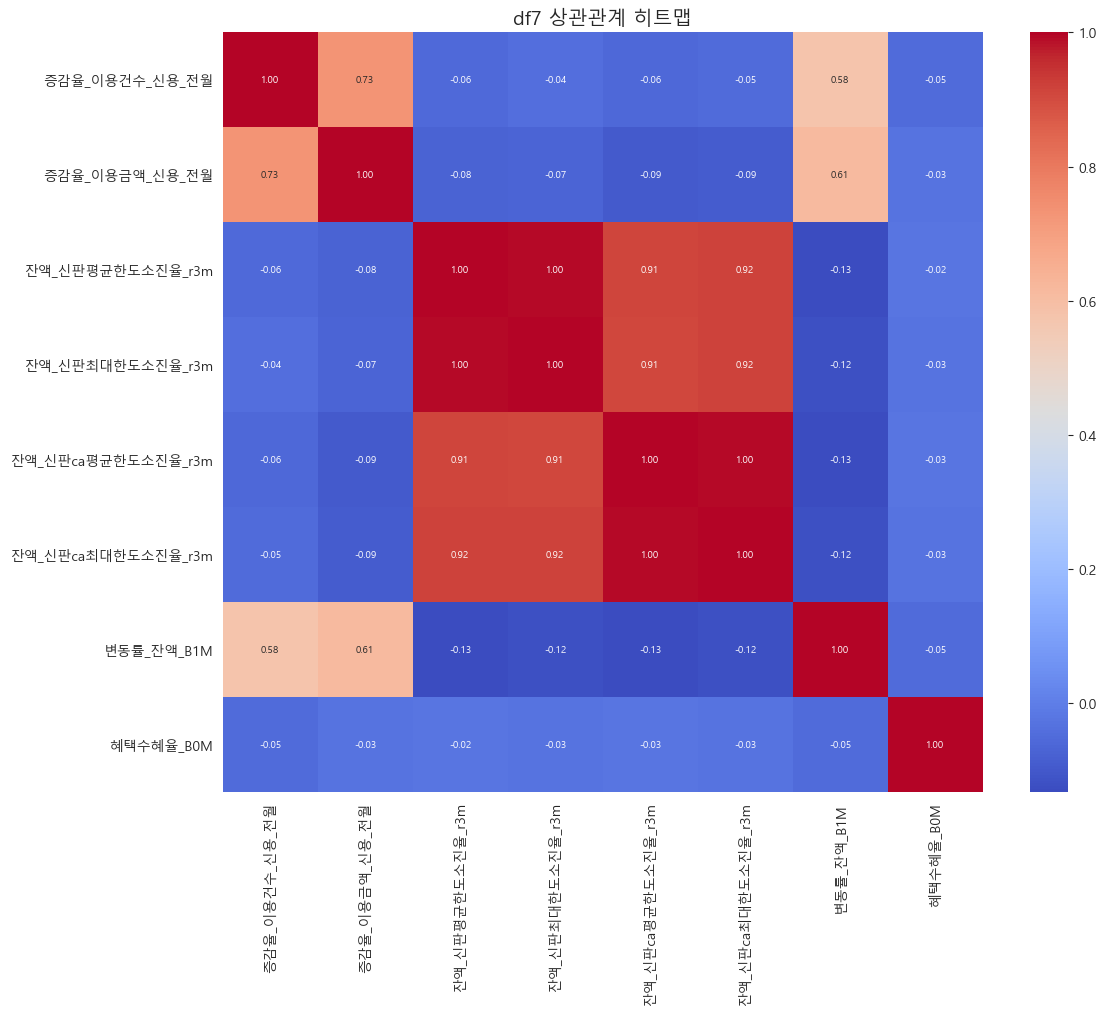

📌 df7의 상관계수 >= 0.8 변수쌍:
               변수1                변수2     상관계수
  잔액_신판평균한도소진율_r3m   잔액_신판최대한도소진율_r3m 0.995461
  잔액_신판평균한도소진율_r3m 잔액_신판ca평균한도소진율_r3m 0.914225
  잔액_신판평균한도소진율_r3m 잔액_신판ca최대한도소진율_r3m 0.917908
  잔액_신판최대한도소진율_r3m 잔액_신판ca평균한도소진율_r3m 0.908028
  잔액_신판최대한도소진율_r3m 잔액_신판ca최대한도소진율_r3m 0.919809
잔액_신판ca평균한도소진율_r3m 잔액_신판ca최대한도소진율_r3m 0.995268 



In [9]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터프레임 리스트
dfs = [df1, df2, df3, df4, df5, df7]  # df6 제외
df_names = ['df1', 'df2', 'df3', 'df4', 'df5', 'df7']

for i, (df, name) in enumerate(zip(dfs, df_names), start=1):
    numeric_df = df.select_dtypes(include='number')
    corr = numeric_df.corr()

    # 히트맵 그리기 (상관계수 숫자 포함)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={'size': 7}, cmap='coolwarm', square=True)
    plt.title(f'{name} 상관관계 히트맵', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 상관계수 0.8 이상인 변수쌍 출력 (자기 자신 제외, 중복 제거)
    print(f'📌 {name}의 상관계수 >= 0.8 변수쌍:')
    high_corr = (
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # 상삼각 행렬만
            .stack()
            .reset_index()
    )
    high_corr.columns = ['변수1', '변수2', '상관계수']
    high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]
    
    if high_corr.empty:
        print('  없음\n')
    else:
        print(high_corr.to_string(index=False), '\n')

In [34]:
# 자동 제거: df1, df2, df7
dfs_auto = [df1, df2, df7]
high_corr_features_to_remove = set()

for df in dfs_auto:
    numeric_df = df.select_dtypes(include='number')
    corr = numeric_df.corr()

    # 상삼각행렬에서 0.8 이상인 쌍만 추출
    high_corr = (
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            .stack()
            .reset_index()
    )
    high_corr.columns = ['변수1', '변수2', '상관계수']
    high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

    # 뒤쪽 변수(변수2)만 수집
    high_corr_features_to_remove.update(high_corr['변수2'].tolist())

# 수동 제거할 변수 42개
manual_remove_features = [
    '이용건수_신판_B0M', '이용건수_CA_B0M', '이용금액_신판_B0M', '이용금액_CA_B0M', '이용금액_카드론_B0M',
    '이용금액_CA_R3M', '이용금액_카드론_R3M', '이용개월수_CA_R3M', '이용개월수_카드론_R3M', '이용가맹점수',
    '이용금액_업종기준', '이용금액_오프라인_R3M', '이용건수_온라인_R3M', '이용건수_오프라인_R3M',
    '이용금액_온라인_B0M', '이용금액_오프라인_B0M', '이용건수_온라인_B0M', '이용건수_오프라인_B0M',
    '이용금액_페이_온라인_R3M', '이용건수_페이_온라인_R3M', '이용금액_페이_온라인_B0M', '이용금액_페이_오프라인_B0M',
    '이용건수_페이_온라인_B0M', '이용건수_페이_오프라인_B0M', '이용금액_연체_R3M', '이용금액_연체_B0M',
    '승인거절건수_한도초과_B0M', '포인트_마일리지_건별_B0M', '포인트_이용포인트_R3M', '마일_이용포인트_R3M',
    '마일_잔여포인트_B0M', '할인건수_B0M', '할인금액_B0M', '혜택수혜금액', '잔액_B0M', '잔액_일시불_B0M',
    '잔액_할부_B0M', '잔액_현금서비스_B0M', '잔액_리볼빙일시불이월_B0M', '잔액_카드론_B0M',
    'RV_최대잔액_R3M', '평잔_RV일시불_3M'
]

# 통합 제거 대상 업데이트
high_corr_features_to_remove.update(manual_remove_features)

# label에서 제거
new_label = label[~label['필드한글명'].isin(high_corr_features_to_remove)].copy()

In [35]:
label.shape #중간중간 빈칸인 행 포함. 원래 119개의 피쳐이름

(125, 2)

In [36]:
new_label.shape

(77, 2)

In [37]:
removed_features = label[~label['필드한글명'].isin(new_label['필드한글명'])]
print("제거된 피처 수:", len(removed_features))
removed_features.head()


제거된 피처 수: 48


,필드한글명,필드영문명
5,소지카드수_이용가능_신용,cnt_credit_member_ups
11,_1순위카드이용금액,amt_1st_card
20,카드이용한도금액_B2M,amt_credit_limit_use_b2m
27,이용건수_신판_B0M,cnt_crsl_b0m
28,이용건수_CA_B0M,cnt_ca_b0m


In [41]:
new_label

,필드한글명,필드영문명
0,VIP등급코드,code_vip
1,최상위카드등급코드,code_topcard_grade
2,회원여부_이용가능,yn_member_ups
3,소지여부_신용,yn_credit_pss
4,소지카드수_유효_신용,cnt_credit_vl_pss
...,...,...
117,증감율_이용건수_신용_전월,ratio_CNT_ccd_B1M
118,증감율_이용금액_신용_전월,ratio_amt_ccd_B1M
119,잔액_신판평균한도소진율_r3m,avg_bal_CRSL_R3M
123,변동률_잔액_B1M,ratio_bal_B1M


In [39]:
new_labels = [label.replace(",", "") for label in new_label]

In [42]:
selected_features = new_label['필드한글명'].tolist()

In [43]:
selected_features

['VIP등급코드',
 '최상위카드등급코드',
 '회원여부_이용가능',
 '소지여부_신용',
 '소지카드수_유효_신용',
 '입회경과개월수_신용',
 '회원여부_연체',
 '탈회횟수_누적',
 '탈회횟수_발급6개월이내',
 '이용금액_R3M_신용',
 '_1순위카드이용건수',
 '연회비발생카드수_B0M',
 '청구금액_기본연회비_B0M',
 '청구금액_제휴연회비_B0M',
 nan,
 '자발한도감액횟수_R12M',
 '강제한도감액횟수_R12M',
 '카드이용한도금액_B1M',
 '한도심사요청건수',
 '한도요청거절건수',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R3M',
 nan,
 '최종이용일자_기본',
 '이용건수_카드론_B0M',
 '이용후경과월_신판',
 '이용후경과월_CA',
 '이용후경과월_카드론',
 '이용건수_신판_R3M',
 '이용건수_CA_R3M',
 '이용건수_카드론_R3M',
 '이용금액_신판_R3M',
 '이용개월수_신판_R3M',
 '증감_RP건수_전월',
 '증감_RP유형건수_전월',
 '이용금액_온라인_R3M',
 '이용금액_페이_오프라인_R3M',
 '이용건수_페이_오프라인_R3M',
 '이용횟수_연체_R3M',
 '이용횟수_연체_B0M',
 '승인거절건수_B0M',
 '승인거절건수_BL_B0M',
 '승인거절건수_R3M',
 '승인거절건수_한도초과_R3M',
 '승인거절건수_BL_R3M',
 '이용금액대',
 nan,
 '포인트_포인트_건별_B0M',
 '포인트_마일리지_월적립_B0M',
 '포인트_포인트_월적립_B0M',
 '포인트_적립포인트_R3M',
 '포인트_잔여포인트_B0M',
 '마일_적립포인트_R3M',
 '할인건수_R3M',
 '할인금액_R3M',
 '연체건수_R3M',
 '혜택수혜금액_R3M',
 nan,
 '연체잔액_B0M',
 '연체일수_B1M',
 '연체원금_B1M',
 '최종연체회차',
 '최종연체개월수_R15M',
 'RV_평균잔액_R3M',
 '평잔_3M',
 '평잔_일시불_3M',
 '평잔

In [44]:
# 1. NaN 제거 + 2. manual_remove_features에 없는 값만 남김
cleaned_selected_features = [
    feat for feat in selected_features
    if pd.notna(feat) and feat not in manual_remove_features
]

In [45]:
cleaned_selected_features

['VIP등급코드',
 '최상위카드등급코드',
 '회원여부_이용가능',
 '소지여부_신용',
 '소지카드수_유효_신용',
 '입회경과개월수_신용',
 '회원여부_연체',
 '탈회횟수_누적',
 '탈회횟수_발급6개월이내',
 '이용금액_R3M_신용',
 '_1순위카드이용건수',
 '연회비발생카드수_B0M',
 '청구금액_기본연회비_B0M',
 '청구금액_제휴연회비_B0M',
 '자발한도감액횟수_R12M',
 '강제한도감액횟수_R12M',
 '카드이용한도금액_B1M',
 '한도심사요청건수',
 '한도요청거절건수',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R3M',
 '최종이용일자_기본',
 '이용건수_카드론_B0M',
 '이용후경과월_신판',
 '이용후경과월_CA',
 '이용후경과월_카드론',
 '이용건수_신판_R3M',
 '이용건수_CA_R3M',
 '이용건수_카드론_R3M',
 '이용금액_신판_R3M',
 '이용개월수_신판_R3M',
 '증감_RP건수_전월',
 '증감_RP유형건수_전월',
 '이용금액_온라인_R3M',
 '이용금액_페이_오프라인_R3M',
 '이용건수_페이_오프라인_R3M',
 '이용횟수_연체_R3M',
 '이용횟수_연체_B0M',
 '승인거절건수_B0M',
 '승인거절건수_BL_B0M',
 '승인거절건수_R3M',
 '승인거절건수_한도초과_R3M',
 '승인거절건수_BL_R3M',
 '이용금액대',
 '포인트_포인트_건별_B0M',
 '포인트_마일리지_월적립_B0M',
 '포인트_포인트_월적립_B0M',
 '포인트_적립포인트_R3M',
 '포인트_잔여포인트_B0M',
 '마일_적립포인트_R3M',
 '할인건수_R3M',
 '할인금액_R3M',
 '연체건수_R3M',
 '혜택수혜금액_R3M',
 '연체잔액_B0M',
 '연체일수_B1M',
 '연체원금_B1M',
 '최종연체회차',
 '최종연체개월수_R15M',
 'RV_평균잔액_R3M',
 '평잔_3M',
 '평잔_일시불_3M',
 '평잔_할부_3M',
 '평잔_CA_3M',
 '

In [47]:
len(cleaned_selected_features)

71

In [49]:
# DataFrame 리스트 및 이름 정의
dfs = [df1, df2, df3, df4, df5, df6, df7]
df_names = ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7']

# 결과 저장
df_feature_map = {}

for df, name in zip(dfs, df_names):
    # 현재 DF의 컬럼 중 cleaned_selected_features에 포함된 것만 필터링
    matched_features = [feat for feat in cleaned_selected_features if feat in df.columns]
    df_feature_map[name] = matched_features

# 결과 출력
for df_name, features in df_feature_map.items():
    print(f"\n{df_name} 포함 피처 ({len(features)}개):")
    print(features)



df1 포함 피처 (14개):
['VIP등급코드', '최상위카드등급코드', '회원여부_이용가능', '소지여부_신용', '소지카드수_유효_신용', '입회경과개월수_신용', '회원여부_연체', '탈회횟수_누적', '탈회횟수_발급6개월이내', '이용금액_R3M_신용', '_1순위카드이용건수', '연회비발생카드수_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M']

df2 포함 피처 (7개):
['자발한도감액횟수_R12M', '강제한도감액횟수_R12M', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수', '시장단기연체여부_R3M', '시장연체상환여부_R3M']

df3 포함 피처 (23개):
['최종이용일자_기본', '이용건수_카드론_B0M', '이용후경과월_신판', '이용후경과월_CA', '이용후경과월_카드론', '이용건수_신판_R3M', '이용건수_CA_R3M', '이용건수_카드론_R3M', '이용금액_신판_R3M', '이용개월수_신판_R3M', '증감_RP건수_전월', '증감_RP유형건수_전월', '이용금액_온라인_R3M', '이용금액_페이_오프라인_R3M', '이용건수_페이_오프라인_R3M', '이용횟수_연체_R3M', '이용횟수_연체_B0M', '승인거절건수_B0M', '승인거절건수_BL_B0M', '승인거절건수_R3M', '승인거절건수_한도초과_R3M', '승인거절건수_BL_R3M', '이용금액대']

df4 포함 피처 (10개):
['포인트_포인트_건별_B0M', '포인트_마일리지_월적립_B0M', '포인트_포인트_월적립_B0M', '포인트_적립포인트_R3M', '포인트_잔여포인트_B0M', '마일_적립포인트_R3M', '할인건수_R3M', '할인금액_R3M', '연체건수_R3M', '혜택수혜금액_R3M']

df5 포함 피처 (11개):
['연체잔액_B0M', '연체일수_B1M', '연체원금_B1M', '최종연체회차', '최종연체개월수_R15M', 'RV_평균잔액_R3M', '평잔_3M', '평잔_일시불_3

In [52]:
import pandas as pd
import os

# 이탈회원목록 불러오기
df_churn = pd.read_csv("이탈회원목록.csv")

# 피처 딕셔너리
features_dict = {
    'df1': ['VIP등급코드', '최상위카드등급코드', '회원여부_이용가능', '소지여부_신용', '소지카드수_유효_신용', '입회경과개월수_신용',
            '회원여부_연체', '탈회횟수_누적', '탈회횟수_발급6개월이내', '이용금액_R3M_신용', '_1순위카드이용건수',
            '연회비발생카드수_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M'],
    'df2': ['자발한도감액횟수_R12M', '강제한도감액횟수_R12M', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수',
            '시장단기연체여부_R3M', '시장연체상환여부_R3M'],
    'df3': ['최종이용일자_기본', '이용건수_카드론_B0M', '이용후경과월_신판', '이용후경과월_CA', '이용후경과월_카드론',
            '이용건수_신판_R3M', '이용건수_CA_R3M', '이용건수_카드론_R3M', '이용금액_신판_R3M', '이용개월수_신판_R3M',
            '증감_RP건수_전월', '증감_RP유형건수_전월', '이용금액_온라인_R3M', '이용금액_페이_오프라인_R3M',
            '이용건수_페이_오프라인_R3M', '이용횟수_연체_R3M', '이용횟수_연체_B0M', '승인거절건수_B0M', '승인거절건수_BL_B0M',
            '승인거절건수_R3M', '승인거절건수_한도초과_R3M', '승인거절건수_BL_R3M', '이용금액대'],
    'df4': ['포인트_포인트_건별_B0M', '포인트_마일리지_월적립_B0M', '포인트_포인트_월적립_B0M', '포인트_적립포인트_R3M',
            '포인트_잔여포인트_B0M', '마일_적립포인트_R3M', '할인건수_R3M', '할인금액_R3M', '연체건수_R3M',
            '혜택수혜금액_R3M'],
    'df5': ['연체잔액_B0M', '연체일수_B1M', '연체원금_B1M', '최종연체회차', '최종연체개월수_R15M', 'RV_평균잔액_R3M',
            '평잔_3M', '평잔_일시불_3M', '평잔_할부_3M', '평잔_CA_3M', '평잔_카드론_3M'],
    'df6': ['불만제기건수_B0M'],
    'df7': ['증감율_이용건수_신용_전월', '증감율_이용금액_신용_전월', '잔액_신판평균한도소진율_r3m', '변동률_잔액_B1M',
            '혜택수혜율_B0M']
}

# 폴더 경로 매핑 함수
def get_folder_map(target_month):
    return {
        'df1': f"01.카드 회원정보/{target_month}_회원정보.csv",
        'df2': f"02.카드 신용정보/{target_month}_신용정보.csv",
        'df3': f"03.카드 승인매출정보/{target_month}_승인매출정보.csv",
        'df4': f"04.카드 청구정보/{target_month}_청구정보.csv",
        'df5': f"05.카드 잔액정보/{target_month}_잔액정보.csv",
        'df6': f"06.카드 채널정보/{target_month}_채널정보.csv",
        'df7': f"08.카드 성과정보/{target_month}_성과정보.csv"
    }

# 병합 함수
def merge_monthly_data(target_month):
    folder_map = get_folder_map(target_month)
    merged = None

    for df_name, path in folder_map.items():
        try:
            df = pd.read_csv(path)
        except FileNotFoundError:
            print(f"[{target_month}] 파일 없음: {path}")
            continue

        df = df[df['발급회원번호'].isin(df_churn['발급회원번호'])]

        use_features = ['발급회원번호'] + features_dict[df_name]
        df = df[use_features].copy()
        df = df.set_index('발급회원번호')

        if merged is None:
            merged = df
        else:
            merged = merged.join(df, how='outer')

    if merged is not None:
        merged = merged.reset_index()
        merged = merged.merge(df_churn, on='발급회원번호', how='left')

        # 저장
        output_filename = f"{target_month}.csv"
        merged.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"[{target_month}] 저장 완료: {output_filename}")
    else:
        print(f"[{target_month}] 병합 실패: 데이터 없음")

# 반복 실행 (201807 ~ 201812)
for month in ['201807', '201808', '201809', '201810', '201811', '201812']:
    merge_monthly_data(month)

[201807] 저장 완료: 201807.csv
[201808] 저장 완료: 201808.csv
[201809] 저장 완료: 201809.csv
[201810] 저장 완료: 201810.csv
[201811] 저장 완료: 201811.csv
[201812] 저장 완료: 201812.csv


In [54]:
# 병합할 월 리스트
months = ['201807', '201808', '201809', '201810', '201811']
all_data = []

# 각 월별 데이터 읽고 'month' 컬럼 추가
for m in months:
    df = pd.read_csv(f"{m}.csv")
    df['month'] = int(m)  # 정렬을 위한 시계열 구분자
    all_data.append(df)

# 아래 방향으로 세로 병합
time_series_df = pd.concat(all_data, axis=0)

# 시계열 순서대로 정렬
time_series_df = time_series_df.sort_values(by=['발급회원번호', 'month']).reset_index(drop=True)

# CSV로 저장
output_path = "concat_timeseries.csv"
time_series_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"시계열 데이터 저장 완료: {output_path}")


시계열 데이터 저장 완료: concat_timeseries.csv


In [63]:
# 파일 경로
file_path = "01.카드 회원정보/201807_회원정보.csv"

# CSV 파일을 컬럼명만 불러오기
df = pd.read_csv(file_path, nrows=0)  # 데이터는 안 읽고 헤더만 읽음
meta_columns = df.columns.tolist()

# 결과 출력
print(meta_columns)

['기준년월', '발급회원번호', '남녀구분코드', '연령', 'VIP등급코드', '최상위카드등급코드', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수', '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '연회비할인카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '청구

In [64]:
exclude_columns = [
    'VIP등급코드', '최상위카드등급코드', '회원여부_이용가능', '소지여부_신용', '소지카드수_유효_신용',
    '입회경과개월수_신용', '회원여부_연체', '탈회횟수_누적', '탈회횟수_발급6개월이내',
    '이용금액_R3M_신용', '_1순위카드이용건수', '연회비발생카드수_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M'
]

In [65]:
meta_columns = [col for col in meta_columns if col not in exclude_columns]

In [66]:
meta_columns

['기준년월',
 '발급회원번호',
 '남녀구분코드',
 '연령',
 '회원여부_이용가능_CA',
 '회원여부_이용가능_카드론',
 '소지카드수_이용가능_신용',
 '입회일자_신용',
 '이용거절여부_카드론',
 '동의여부_한도증액안내',
 '수신거부여부_TM',
 '수신거부여부_DM',
 '수신거부여부_메일',
 '수신거부여부_SMS',
 '가입통신회사코드',
 '최종탈회후경과월',
 '탈회횟수_발급1년이내',
 '거주시도명',
 '직장시도명',
 '마케팅동의여부',
 '유효카드수_신용체크',
 '유효카드수_신용',
 '유효카드수_신용_가족',
 '유효카드수_체크',
 '유효카드수_체크_가족',
 '이용가능카드수_신용체크',
 '이용가능카드수_신용',
 '이용가능카드수_신용_가족',
 '이용가능카드수_체크',
 '이용가능카드수_체크_가족',
 '이용카드수_신용체크',
 '이용카드수_신용',
 '이용카드수_신용_가족',
 '이용카드수_체크',
 '이용카드수_체크_가족',
 '이용금액_R3M_신용체크',
 '이용금액_R3M_신용_가족',
 '이용금액_R3M_체크',
 '이용금액_R3M_체크_가족',
 '_1순위카드이용금액',
 '_1순위신용체크구분',
 '_2순위카드이용금액',
 '_2순위카드이용건수',
 '_2순위신용체크구분',
 '최종유효년월_신용_이용가능',
 '최종유효년월_신용_이용',
 '최종카드발급일자',
 '보유여부_해외겸용_본인',
 '이용가능여부_해외겸용_본인',
 '이용여부_3M_해외겸용_본인',
 '보유여부_해외겸용_신용_본인',
 '이용가능여부_해외겸용_신용_본인',
 '이용여부_3M_해외겸용_신용_본인',
 '연회비할인카드수_B0M',
 '기본연회비_B0M',
 '제휴연회비_B0M',
 '할인금액_기본연회비_B0M',
 '할인금액_제휴연회비_B0M',
 '상품관련면제카드수_B0M',
 '임직원면제카드수_B0M',
 '우수회원면제카드수_B0M',
 '기타면제카드수_B0M',
 '카드신청건수',
 'Life_Stage',
 '최종카드발급경과월

In [70]:
meta_columns = [
    '발급회원번호',          # 고유 식별자
    '남녀구분코드',          # 성별
    '연령',                # 연령대
    '가입통신회사코드',       # 통신사
    '거주시도명',            # 거주지
    '직장시도명',            # 직장 위치
    '마케팅동의여부',         # 마케팅 동의
    '수신거부여부_TM',       
    '수신거부여부_DM',       
    '수신거부여부_메일',     
    '수신거부여부_SMS',
    'Life_Stage',          # 라이프 스테이지
    '최종카드발급경과월'       # 마지막 발급 후 경과 월
]

In [71]:
import pandas as pd

# 이탈회원목록 불러오기
df_churns = pd.read_csv("이탈회원목록.csv")

# 회원정보 데이터 불러오기
member_df = pd.read_csv("01.카드 회원정보/201812_회원정보.csv")

# 이탈회원 필터링
filtered = member_df[member_df['발급회원번호'].isin(df_churn['발급회원번호'])]

# 메타컬럼만 추출
meta_df = filtered[meta_columns].copy()

# 이탈회원 정보와 병합 (발급회원번호 기준)
final_df = pd.merge(meta_df, df_churn, on='발급회원번호', how='left')

# 저장
final_df.to_csv("meta.csv", index=False, encoding='utf-8-sig')

In [72]:
df = pd.read_csv("meta.csv")

# 범주형 변수 One-Hot Encoding
categorical_cols = ['연령', '가입통신회사코드', '거주시도명', '직장시도명', 'Life_Stage']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 전처리된 데이터 저장
df_encoded.to_csv("meta_processed.csv", index=False, encoding='utf-8-sig')

In [80]:
# 파일 불러오기
meta_df = pd.read_csv("meta_processed.csv")
churn_df = pd.read_csv("이탈회원목록.csv")

# 발급회원번호 → customer_id로 컬럼명 통일
if 'customer_id' not in meta_df.columns:
    meta_df = meta_df.rename(columns={'발급회원번호': 'customer_id'})
if 'customer_id' not in churn_df.columns:
    churn_df = churn_df.rename(columns={'발급회원번호': 'customer_id'})
    
# '이탈' 컬럼을 'churn'으로 변경
churn_df = churn_df.rename(columns={'이탈': 'churn'})

# 병합: customer_id 기준으로 이탈 여부 포함
merged_df = pd.merge(meta_df, churn_df[['customer_id', 'churn']], on='customer_id', how='inner')

# 결과 저장
merged_df.to_csv("meta_merged.csv", index=False)

In [81]:
merged_df.columns

Index(['customer_id', '남녀구분코드', '마케팅동의여부', '수신거부여부_TM', '수신거부여부_DM',
       '수신거부여부_메일', '수신거부여부_SMS', '최종카드발급경과월', '이탈', '연령_20대', '연령_30대',
       '연령_40대', '연령_50대', '연령_60대', '연령_70대이상', '가입통신회사코드_KTF',
       '가입통신회사코드_LGT', '가입통신회사코드_SKT', '거주시도명_강원', '거주시도명_경기', '거주시도명_경남',
       '거주시도명_경북', '거주시도명_광주', '거주시도명_대구', '거주시도명_대전', '거주시도명_부산', '거주시도명_서울',
       '거주시도명_세종', '거주시도명_울산', '거주시도명_인천', '거주시도명_전남', '거주시도명_전북', '거주시도명_제주',
       '거주시도명_충남', '거주시도명_충북', '직장시도명_강원', '직장시도명_경기', '직장시도명_경남', '직장시도명_경북',
       '직장시도명_광주', '직장시도명_대구', '직장시도명_대전', '직장시도명_부산', '직장시도명_서울', '직장시도명_세종',
       '직장시도명_울산', '직장시도명_인천', '직장시도명_전남', '직장시도명_전북', '직장시도명_제주', '직장시도명_충남',
       '직장시도명_충북', 'Life_Stage_1.Single', 'Life_Stage_2.가족형성기',
       'Life_Stage_3.자녀출산기', 'Life_Stage_4.자녀성장기(1)', 'Life_Stage_5.자녀성장기(2)',
       'Life_Stage_6.자녀출가기', 'Life_Stage_7.노령', 'churn'],
      dtype='object')

In [96]:
# 파일 경로
file_path = "concat_timeseries.csv"

# CSV 파일을 컬럼명만 불러오기
df = pd.read_csv(file_path) 
time_columns = df.columns.tolist()

# 결과 출력
df

,발급회원번호,VIP등급코드,최상위카드등급코드,회원여부_이용가능,소지여부_신용,소지카드수_유효_신용,입회경과개월수_신용,회원여부_연체,탈회횟수_누적,탈회횟수_발급6개월이내,...,평잔_CA_3M,평잔_카드론_3M,불만제기건수_B0M,증감율_이용건수_신용_전월,증감율_이용금액_신용_전월,잔액_신판평균한도소진율_r3m,변동률_잔액_B1M,혜택수혜율_B0M,이탈,month
0,SYN_0,07,_,1,1,1,67,0,1,0,...,2155023,0,0,0.454549,0.409767,0.154402,0.261886,1.280545,0,201807
1,SYN_0,07,_,1,1,1,68,0,1,0,...,2386636,0,0,-0.097118,0.192772,0.109176,-0.140747,1.555700,0,201808
2,SYN_0,07,_,1,1,1,69,0,1,0,...,2598395,0,0,0.015812,0.250440,0.115650,-0.057002,1.407224,0,201809
3,SYN_0,07,_,1,1,1,70,0,1,0,...,2544537,0,0,-0.057331,0.222442,0.094474,-0.083067,1.587247,0,201810
4,SYN_0,07,_,1,1,1,71,0,1,0,...,2576282,0,0,-0.036637,0.244219,0.083612,-0.038451,1.478968,0,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11106280,SYN_999999,_,_,1,1,1,69,0,1,0,...,0,0,0,0.050997,0.331479,0.039732,0.189133,0.000000,0,201807
11106281,SYN_999999,_,_,1,1,1,70,0,1,0,...,0,0,0,-0.212373,-1.999466,0.052002,-0.055758,0.000000,0,201808
11106282,SYN_999999,_,_,1,1,1,71,0,1,0,...,0,0,0,-0.193278,-2.000037,0.038671,-0.148673,0.000000,0,201809
11106283,SYN_999999,_,_,1,1,1,72,0,1,0,...,0,0,0,0.060581,-1.999103,0.024053,-0.009538,0.000000,0,201810


In [97]:
time_columns

['발급회원번호',
 'VIP등급코드',
 '최상위카드등급코드',
 '회원여부_이용가능',
 '소지여부_신용',
 '소지카드수_유효_신용',
 '입회경과개월수_신용',
 '회원여부_연체',
 '탈회횟수_누적',
 '탈회횟수_발급6개월이내',
 '이용금액_R3M_신용',
 '_1순위카드이용건수',
 '연회비발생카드수_B0M',
 '청구금액_기본연회비_B0M',
 '청구금액_제휴연회비_B0M',
 '자발한도감액횟수_R12M',
 '강제한도감액횟수_R12M',
 '카드이용한도금액_B1M',
 '한도심사요청건수',
 '한도요청거절건수',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R3M',
 '최종이용일자_기본',
 '이용건수_카드론_B0M',
 '이용후경과월_신판',
 '이용후경과월_CA',
 '이용후경과월_카드론',
 '이용건수_신판_R3M',
 '이용건수_CA_R3M',
 '이용건수_카드론_R3M',
 '이용금액_신판_R3M',
 '이용개월수_신판_R3M',
 '증감_RP건수_전월',
 '증감_RP유형건수_전월',
 '이용금액_온라인_R3M',
 '이용금액_페이_오프라인_R3M',
 '이용건수_페이_오프라인_R3M',
 '이용횟수_연체_R3M',
 '이용횟수_연체_B0M',
 '승인거절건수_B0M',
 '승인거절건수_BL_B0M',
 '승인거절건수_R3M',
 '승인거절건수_한도초과_R3M',
 '승인거절건수_BL_R3M',
 '이용금액대',
 '포인트_포인트_건별_B0M',
 '포인트_마일리지_월적립_B0M',
 '포인트_포인트_월적립_B0M',
 '포인트_적립포인트_R3M',
 '포인트_잔여포인트_B0M',
 '마일_적립포인트_R3M',
 '할인건수_R3M',
 '할인금액_R3M',
 '연체건수_R3M',
 '혜택수혜금액_R3M',
 '연체잔액_B0M',
 '연체일수_B1M',
 '연체원금_B1M',
 '최종연체회차',
 '최종연체개월수_R15M',
 'RV_평균잔액_R3M',
 '평잔_3M',
 '평잔_일시불_3M',
 '평잔_할부_3M',
 '평잔

In [98]:
df = df.rename(columns={
    '발급회원번호': 'customer_id',
    '이탈': 'churn'
})

In [99]:
df

,customer_id,VIP등급코드,최상위카드등급코드,회원여부_이용가능,소지여부_신용,소지카드수_유효_신용,입회경과개월수_신용,회원여부_연체,탈회횟수_누적,탈회횟수_발급6개월이내,...,평잔_CA_3M,평잔_카드론_3M,불만제기건수_B0M,증감율_이용건수_신용_전월,증감율_이용금액_신용_전월,잔액_신판평균한도소진율_r3m,변동률_잔액_B1M,혜택수혜율_B0M,churn,month
0,SYN_0,07,_,1,1,1,67,0,1,0,...,2155023,0,0,0.454549,0.409767,0.154402,0.261886,1.280545,0,201807
1,SYN_0,07,_,1,1,1,68,0,1,0,...,2386636,0,0,-0.097118,0.192772,0.109176,-0.140747,1.555700,0,201808
2,SYN_0,07,_,1,1,1,69,0,1,0,...,2598395,0,0,0.015812,0.250440,0.115650,-0.057002,1.407224,0,201809
3,SYN_0,07,_,1,1,1,70,0,1,0,...,2544537,0,0,-0.057331,0.222442,0.094474,-0.083067,1.587247,0,201810
4,SYN_0,07,_,1,1,1,71,0,1,0,...,2576282,0,0,-0.036637,0.244219,0.083612,-0.038451,1.478968,0,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11106280,SYN_999999,_,_,1,1,1,69,0,1,0,...,0,0,0,0.050997,0.331479,0.039732,0.189133,0.000000,0,201807
11106281,SYN_999999,_,_,1,1,1,70,0,1,0,...,0,0,0,-0.212373,-1.999466,0.052002,-0.055758,0.000000,0,201808
11106282,SYN_999999,_,_,1,1,1,71,0,1,0,...,0,0,0,-0.193278,-2.000037,0.038671,-0.148673,0.000000,0,201809
11106283,SYN_999999,_,_,1,1,1,72,0,1,0,...,0,0,0,0.060581,-1.999103,0.024053,-0.009538,0.000000,0,201810


In [102]:
unique_counts = df.nunique()
print(unique_counts)

customer_id         2221257
VIP등급코드                   5
최상위카드등급코드                 5
회원여부_이용가능                 2
소지여부_신용                   2
                     ...   
잔액_신판평균한도소진율_r3m    8514353
변동률_잔액_B1M          9769638
혜택수혜율_B0M           5534322
churn                     2
month                     5
Length: 74, dtype: int64


In [103]:
print(unique_counts[unique_counts <= 10])

VIP등급코드              5
최상위카드등급코드            5
회원여부_이용가능            2
소지여부_신용              2
소지카드수_유효_신용          5
회원여부_연체              2
탈회횟수_누적              3
탈회횟수_발급6개월이내         2
연회비발생카드수_B0M         2
자발한도감액횟수_R12M        5
강제한도감액횟수_R12M        5
한도심사요청건수             2
한도요청거절건수             2
시장단기연체여부_R3M         2
시장연체상환여부_R3M         1
이용건수_카드론_B0M         2
이용건수_CA_R3M         10
이용건수_카드론_R3M         2
이용개월수_신판_R3M         4
증감_RP유형건수_전월         3
이용건수_페이_오프라인_R3M     4
이용횟수_연체_R3M          4
이용횟수_연체_B0M          2
승인거절건수_B0M           4
승인거절건수_BL_B0M        2
승인거절건수_한도초과_R3M      5
승인거절건수_BL_R3M        6
이용금액대                6
연체건수_R3M             5
최종연체회차               2
최종연체개월수_R15M         7
불만제기건수_B0M           1
churn                2
month                5
dtype: int64


In [106]:
# 최종 시계열 입력 데이터 준비
time_series_df = df.copy()

# One-Hot Encoding 대상 컬럼
categorical_cols = [
    '최상위카드등급코드',      # 등급 (범주형)
    '회원여부_이용가능',      # 이진 여부 (1/0)
    '회원여부_연체',          # 이진 여부 (1/0)
    '소지여부_신용',          # 이진 여부 (1/0)
    'VIP등급코드',          # VIP 등급 (범주형)
    '이용금액대',            # 금액 구간 (범주형)
    '시장연체상환여부_R3M',   # 이진 여부
    '시장단기연체여부_R3M',   # 이진 여부
    '최종연체회차'           # 연체 회차 (범주형 소수값)
]

# One-Hot Encoding 수행
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 인코딩된 결과 저장
df_encoded.to_csv("processed_time_series.csv", index=False)

In [4]:
import pandas as pd
import numpy as np

# CSV 파일 로드
df = pd.read_csv('meta_merged.csv')

if '이탈' in df.columns:
    df.drop(columns=['이탈'], inplace=True)

# True / False → 0 / 1 (bool → int8)
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
df[bool_cols] = df[bool_cols].astype('int8')

# 문자열이지만 숫자로 보이는 열 처리 ('0 ', '1 ' 등 → 숫자)
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.strip(), errors='raise')
        except:
            pass  # 숫자로 변환 불가한 경우는 건너뜀

# 전체 수치형 컬럼 메모리 최적화
for col in df.columns:
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].astype('int8')  # 대부분 one-hot → int8로 충분
    elif pd.api.types.is_float_dtype(df[col]):
        df[col] = df[col].astype('float32')

# 저장
df.to_csv('meta_merged_processed.csv', index=False)

df

,customer_id,남녀구분코드,마케팅동의여부,수신거부여부_TM,수신거부여부_DM,수신거부여부_메일,수신거부여부_SMS,최종카드발급경과월,연령_20대,연령_30대,...,직장시도명_충남,직장시도명_충북,Life_Stage_1.Single,Life_Stage_2.가족형성기,Life_Stage_3.자녀출산기,Life_Stage_4.자녀성장기(1),Life_Stage_5.자녀성장기(2),Life_Stage_6.자녀출가기,Life_Stage_7.노령,churn
0,SYN_0,2,1,0,0,0,0,27,0,0,...,0,0,0,0,0,0,1,0,0,0
1,SYN_1,1,1,0,0,0,0,23,0,1,...,0,0,0,0,0,1,0,0,0,0
2,SYN_3,1,1,1,1,1,0,48,0,0,...,1,0,0,0,0,1,0,0,0,0
3,SYN_7,2,1,0,0,0,0,20,0,0,...,0,0,0,0,0,0,1,0,0,0
4,SYN_8,1,1,0,0,0,0,49,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221252,SYN_2999991,2,0,1,1,1,1,37,0,1,...,0,0,0,1,0,0,0,0,0,0
2221253,SYN_2999994,2,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2221254,SYN_2999996,1,0,1,1,1,1,5,0,0,...,0,0,0,0,0,0,1,0,0,0
2221255,SYN_2999997,2,1,1,1,1,0,20,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
print(df.isnull().sum())

customer_id              0
남녀구분코드                   0
마케팅동의여부                  0
수신거부여부_TM                0
수신거부여부_DM                0
수신거부여부_메일                0
수신거부여부_SMS               0
최종카드발급경과월                0
연령_20대                   0
연령_30대                   0
연령_40대                   0
연령_50대                   0
연령_60대                   0
연령_70대이상                 0
가입통신회사코드_KTF             0
가입통신회사코드_LGT             0
가입통신회사코드_SKT             0
거주시도명_강원                 0
거주시도명_경기                 0
거주시도명_경남                 0
거주시도명_경북                 0
거주시도명_광주                 0
거주시도명_대구                 0
거주시도명_대전                 0
거주시도명_부산                 0
거주시도명_서울                 0
거주시도명_세종                 0
거주시도명_울산                 0
거주시도명_인천                 0
거주시도명_전남                 0
거주시도명_전북                 0
거주시도명_제주                 0
거주시도명_충남                 0
거주시도명_충북                 0
직장시도명_강원                 0
직장시도명_경기                 0
직장시도명_경남                 0
직

In [6]:
print(df['churn'].value_counts())

churn
0    2209849
1      11408
Name: count, dtype: int64


In [8]:
# 1. Positive (churn = 1)
df_pos = df[df['churn'] == 1]

# 2. Negative (churn = 0) → 랜덤 샘플링
df_neg = df[df['churn'] == 0].sample(n=len(df_pos)*5, random_state=42)

# 3. 합치고 섞기
df_balanced = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# 4. 확인
print(df_balanced['churn'].value_counts())

# 5. 파일로 저장
df_balanced.to_csv('meta_merged_balanced.csv', index=False)
print("저장 완료: meta_merged_balanced.csv")


churn
0    57040
1    11408
Name: count, dtype: int64
저장 완료: meta_merged_balanced.csv


In [10]:
df_balanced = pd.read_csv('meta_merged_balanced.csv')

# churn 값 별 개수 확인
print(df_balanced['churn'].value_counts())


churn
0    57040
1    11408
Name: count, dtype: int64


In [11]:
df_balanced

,customer_id,남녀구분코드,마케팅동의여부,수신거부여부_TM,수신거부여부_DM,수신거부여부_메일,수신거부여부_SMS,최종카드발급경과월,연령_20대,연령_30대,...,직장시도명_충남,직장시도명_충북,Life_Stage_1.Single,Life_Stage_2.가족형성기,Life_Stage_3.자녀출산기,Life_Stage_4.자녀성장기(1),Life_Stage_5.자녀성장기(2),Life_Stage_6.자녀출가기,Life_Stage_7.노령,churn
0,SYN_912461,1,1,1,1,1,1,23,1,0,...,0,0,1,0,0,0,0,0,0,1
1,SYN_2185317,2,1,0,0,0,1,37,0,1,...,0,0,0,0,0,1,0,0,0,0
2,SYN_718044,1,0,0,1,1,1,5,0,0,...,0,0,0,0,0,0,0,0,1,0
3,SYN_2631358,2,1,0,0,0,0,11,0,0,...,0,0,0,0,0,0,1,0,0,0
4,SYN_1219859,1,0,1,1,1,0,29,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68443,SYN_2021131,1,1,0,0,0,1,13,0,1,...,0,0,0,0,1,0,0,0,0,0
68444,SYN_1653168,1,1,0,0,0,0,30,0,1,...,0,0,0,1,0,0,0,0,0,1
68445,SYN_2270038,2,1,0,0,0,0,18,0,0,...,0,0,0,0,0,0,0,1,0,0
68446,SYN_223814,2,1,0,0,0,1,61,0,1,...,0,0,0,0,1,0,0,0,0,1


In [12]:
import pandas as pd

df = pd.read_csv('processed_time_series.csv')

In [21]:
df.head()

,customer_id,소지카드수_유효_신용,입회경과개월수_신용,탈회횟수_누적,탈회횟수_발급6개월이내,이용금액_R3M_신용,_1순위카드이용건수,연회비발생카드수_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,...,이용금액대_02.50만원+,이용금액대_03.30만원+,이용금액대_04.10만원+,이용금액대_05.10만원-,이용금액대_09.미사용,시장연체상환여부_R3M_0,시장단기연체여부_R3M_0,시장단기연체여부_R3M_1,최종연체회차_-9999,최종연체회차_0
0,SYN_0,1,67,1,0,19612,26,0,0,0,...,False,False,False,False,False,True,True,False,False,True
1,SYN_0,1,68,1,0,-119082,23,0,0,0,...,False,False,False,False,False,True,True,False,False,True
2,SYN_0,1,69,1,0,86863,27,0,0,0,...,False,False,False,False,False,True,True,False,False,True
3,SYN_0,1,70,1,0,-36713,26,0,0,0,...,False,False,False,False,False,True,True,False,False,True
4,SYN_0,1,71,1,0,-47805,26,0,0,0,...,False,False,False,False,False,True,True,False,False,True


In [22]:
df.columns

Index(['customer_id', '소지카드수_유효_신용', '입회경과개월수_신용', '탈회횟수_누적', '탈회횟수_발급6개월이내',
       '이용금액_R3M_신용', '_1순위카드이용건수', '연회비발생카드수_B0M', '청구금액_기본연회비_B0M',
       '청구금액_제휴연회비_B0M', '자발한도감액횟수_R12M', '강제한도감액횟수_R12M', '카드이용한도금액_B1M',
       '한도심사요청건수', '한도요청거절건수', '최종이용일자_기본', '이용건수_카드론_B0M', '이용후경과월_신판',
       '이용후경과월_CA', '이용후경과월_카드론', '이용건수_신판_R3M', '이용건수_CA_R3M', '이용건수_카드론_R3M',
       '이용금액_신판_R3M', '이용개월수_신판_R3M', '증감_RP건수_전월', '증감_RP유형건수_전월',
       '이용금액_온라인_R3M', '이용금액_페이_오프라인_R3M', '이용건수_페이_오프라인_R3M', '이용횟수_연체_R3M',
       '이용횟수_연체_B0M', '승인거절건수_B0M', '승인거절건수_BL_B0M', '승인거절건수_R3M',
       '승인거절건수_한도초과_R3M', '승인거절건수_BL_R3M', '포인트_포인트_건별_B0M',
       '포인트_마일리지_월적립_B0M', '포인트_포인트_월적립_B0M', '포인트_적립포인트_R3M', '포인트_잔여포인트_B0M',
       '마일_적립포인트_R3M', '할인건수_R3M', '할인금액_R3M', '연체건수_R3M', '혜택수혜금액_R3M',
       '연체잔액_B0M', '연체일수_B1M', '연체원금_B1M', '최종연체개월수_R15M', 'RV_평균잔액_R3M',
       '평잔_3M', '평잔_일시불_3M', '평잔_할부_3M', '평잔_CA_3M', '평잔_카드론_3M', '불만제기건수_B0M',
       '증감율_이용건수_신용_전월', '증감율_이용금액_신용_전월', 

In [13]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False))


Column: customer_id
customer_id
SYN_0          5
SYN_2799637    5
SYN_2799654    5
SYN_2799653    5
SYN_2799652    5
              ..
SYN_1899718    5
SYN_1899716    5
SYN_1899712    5
SYN_1899711    5
SYN_999999     5
Name: count, Length: 2221257, dtype: int64

Column: 소지카드수_유효_신용
소지카드수_유효_신용
1    8156331
2    2210447
3     735164
0       3967
4        376
Name: count, dtype: int64

Column: 입회경과개월수_신용
입회경과개월수_신용
6      353130
5      333791
4      312471
3      292137
2      271609
        ...  
333         2
334         1
335         1
336         1
337         1
Name: count, Length: 336, dtype: int64

Column: 탈회횟수_누적
탈회횟수_누적
0    6621921
1    3488407
2     995957
Name: count, dtype: int64

Column: 탈회횟수_발급6개월이내
탈회횟수_발급6개월이내
0    10663816
1      442469
Name: count, dtype: int64

Column: 이용금액_R3M_신용
이용금액_R3M_신용
0          295774
497940         19
958884         16
278699         15
410435         15
            ...  
3410575         1
6776002         1
6829374         1
7164697        

In [17]:
expanded_features = [
    '소지카드수_유효_신용', '연회비발생카드수_B0M', '탈회횟수_발급6개월이내',
    '강제한도감액횟수_R12M', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수',
    '승인거절건수_R3M', '이용횟수_연체_R3M', '증감_RP건수_전월', '최종이용일자_기본',
    '연체건수_R3M', '혜택수혜금액_R3M', '연체원금_B1M', '연체일수_B1M', '평잔_3M',
    '불만제기건수_B0M', '변동률_잔액_B1M', '잔액_신판평균한도소진율_r3m', '증감율_이용건수_신용_전월',
    'VIP등급코드_04', 'VIP등급코드_05', 'VIP등급코드_06', 'VIP등급코드_07', 'VIP등급코드__',
    '시장연체상환여부_R3M_0',
    '시장단기연체여부_R3M_0', '시장단기연체여부_R3M_1',
    '이용금액대_01.100만원+', '이용금액대_02.50만원+', '이용금액대_03.30만원+',
    '이용금액대_04.10만원+', '이용금액대_05.10만원-', '이용금액대_09.미사용'
]

columns_to_keep = ['customer_id', 'month'] + expanded_features

df_selected = df[columns_to_keep]

df_selected.to_csv('time_expanded_features.csv', index=False)

print("선택된 피처 수:", len(df_selected.columns))
print("컬럼 목록:", df_selected.columns.tolist())

선택된 피처 수: 36
컬럼 목록: ['customer_id', 'month', '소지카드수_유효_신용', '연회비발생카드수_B0M', '탈회횟수_발급6개월이내', '강제한도감액횟수_R12M', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수', '승인거절건수_R3M', '이용횟수_연체_R3M', '증감_RP건수_전월', '최종이용일자_기본', '연체건수_R3M', '혜택수혜금액_R3M', '연체원금_B1M', '연체일수_B1M', '평잔_3M', '불만제기건수_B0M', '변동률_잔액_B1M', '잔액_신판평균한도소진율_r3m', '증감율_이용건수_신용_전월', 'VIP등급코드_04', 'VIP등급코드_05', 'VIP등급코드_06', 'VIP등급코드_07', 'VIP등급코드__', '시장연체상환여부_R3M_0', '시장단기연체여부_R3M_0', '시장단기연체여부_R3M_1', '이용금액대_01.100만원+', '이용금액대_02.50만원+', '이용금액대_03.30만원+', '이용금액대_04.10만원+', '이용금액대_05.10만원-', '이용금액대_09.미사용']


In [18]:
meta_df = pd.read_csv('meta_merged_balanced.csv')
target_ids = set(meta_df['customer_id'])

time_df = pd.read_csv('time_expanded_features.csv')

# customer_id가 기준 리스트에 포함된 경우만
filtered_time_df = time_df[time_df['customer_id'].isin(target_ids)].reset_index(drop=True)

# 저장
filtered_time_df.to_csv('time_expanded_features_filtered.csv', index=False)

# 확인
print(f"원본 시계열 데이터: {len(time_df)}개")
print(f"필터링된 시계열 데이터: {len(filtered_time_df)}개")

원본 시계열 데이터: 11106285개
필터링된 시계열 데이터: 342240개


In [19]:
meta_unique_ids = meta_df['customer_id'].nunique()
filtered_unique_ids = filtered_time_df['customer_id'].nunique()

print(f"meta_df의 유니크 customer_id 수: {meta_unique_ids}")
print(f"filtered_time_df의 유니크 customer_id 수: {filtered_unique_ids}")

meta_df의 유니크 customer_id 수: 68448
filtered_time_df의 유니크 customer_id 수: 68448


In [24]:
selected_features = [
    # df1
    'VIP등급코드_04', 'VIP등급코드_05', 'VIP등급코드_06', 'VIP등급코드_07', 'VIP등급코드__',
    '소지카드수_유효_신용', '연회비발생카드수_B0M', '탈회횟수_발급6개월이내',

    # df2
    '강제한도감액횟수_R12M', '시장단기연체여부_R3M_0', '시장단기연체여부_R3M_1',
    '시장연체상환여부_R3M_0', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수',

    # df3
    '승인거절건수_B0M', '이용금액대_01.100만원+', '이용금액대_02.50만원+', '이용금액대_03.30만원+',
    '이용금액대_04.10만원+', '이용금액대_05.10만원-', '이용금액대_09.미사용',
    '이용횟수_연체_B0M', '증감_RP건수_전월', '최종이용일자_기본',

    # df4
    '연체건수_R3M', '혜택수혜금액_R3M',

    # df5
    '연체원금_B1M', '연체일수_B1M',

    # df6
    '불만제기건수_B0M',

    # df7
    '변동률_잔액_B1M', '잔액_신판평균한도소진율_r3m', '증감율_이용건수_신용_전월'
]


selected_features = ['customer_id', 'month'] + selected_features

df_selected = df[columns_to_keep]

df_selected.to_csv('time_selected_features.csv', index=False)

print("선택된 피처 수:", len(df_selected.columns))
print("컬럼 목록:", df_selected.columns.tolist())

선택된 피처 수: 36
컬럼 목록: ['customer_id', 'month', '소지카드수_유효_신용', '연회비발생카드수_B0M', '탈회횟수_발급6개월이내', '강제한도감액횟수_R12M', '카드이용한도금액_B1M', '한도심사요청건수', '한도요청거절건수', '승인거절건수_R3M', '이용횟수_연체_R3M', '증감_RP건수_전월', '최종이용일자_기본', '연체건수_R3M', '혜택수혜금액_R3M', '연체원금_B1M', '연체일수_B1M', '평잔_3M', '불만제기건수_B0M', '변동률_잔액_B1M', '잔액_신판평균한도소진율_r3m', '증감율_이용건수_신용_전월', 'VIP등급코드_04', 'VIP등급코드_05', 'VIP등급코드_06', 'VIP등급코드_07', 'VIP등급코드__', '시장연체상환여부_R3M_0', '시장단기연체여부_R3M_0', '시장단기연체여부_R3M_1', '이용금액대_01.100만원+', '이용금액대_02.50만원+', '이용금액대_03.30만원+', '이용금액대_04.10만원+', '이용금액대_05.10만원-', '이용금액대_09.미사용']


In [25]:
meta_df = pd.read_csv('meta_merged_balanced.csv')
target_ids = set(meta_df['customer_id'])

time_df = pd.read_csv('time_selected_features.csv')

# customer_id가 기준 리스트에 포함된 경우만
filtered_time_df = time_df[time_df['customer_id'].isin(target_ids)].reset_index(drop=True)

# 저장
filtered_time_df.to_csv('time_selected_features_filtered.csv', index=False)

# 확인
print(f"원본 시계열 데이터: {len(time_df)}개")
print(f"필터링된 시계열 데이터: {len(filtered_time_df)}개")

원본 시계열 데이터: 11106285개
필터링된 시계열 데이터: 342240개


In [26]:
meta_unique_ids = meta_df['customer_id'].nunique()
filtered_unique_ids = filtered_time_df['customer_id'].nunique()

print(f"meta_df의 유니크 customer_id 수: {meta_unique_ids}")
print(f"filtered_time_df의 유니크 customer_id 수: {filtered_unique_ids}")

meta_df의 유니크 customer_id 수: 68448
filtered_time_df의 유니크 customer_id 수: 68448


In [34]:
meta_df = pd.read_csv('meta_merged_balanced.csv')
target_ids = set(meta_df['customer_id'])

# customer_id가 기준 리스트에 포함된 경우만
time_df = df[df['customer_id'].isin(target_ids)].reset_index(drop=True)

# 저장
time_df.to_csv('time_sample_filtered.csv', index=False)

# 확인
print(f"원본 시계열 데이터: {len(df)}개")
print(f"필터링된 시계열 데이터: {len(time_df)}개")

원본 시계열 데이터: 11106285개
필터링된 시계열 데이터: 342240개


In [35]:
meta_unique_ids = meta_df['customer_id'].nunique()
time_df_ids = time_df['customer_id'].nunique()

print(f"meta_df의 유니크 customer_id 수: {meta_unique_ids}")
print(f"filtered_time_df의 유니크 customer_id 수: {time_df_ids}")

meta_df의 유니크 customer_id 수: 68448
filtered_time_df의 유니크 customer_id 수: 68448


In [ ]:
tim